In [5]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost mlxtend

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1) Análise Exploratória

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1460 non-null   float64
 1   MSSubClass      1460 non-null   float64
 2   MSZoning        1460 non-null   float64
 3   LotFrontage     1460 non-null   float64
 4   LotArea         1460 non-null   float64
 5   Street          1460 non-null   float64
 6   Alley           1460 non-null   float64
 7   LotShape        1460 non-null   float64
 8   LandContour     1460 non-null   float64
 9   Utilities       1460 non-null   float64
 10  LotConfig       1460 non-null   float64
 11  LandSlope       1460 non-null   float64
 12  Neighborhood    1460 non-null   float64
 13  Condition1      1460 non-null   float64
 14  Condition2      1460 non-null   float64
 15  BldgType        1460 non-null   float64
 16  HouseStyle      1460 non-null   float64
 17  OverallQual     1460 non-null   f

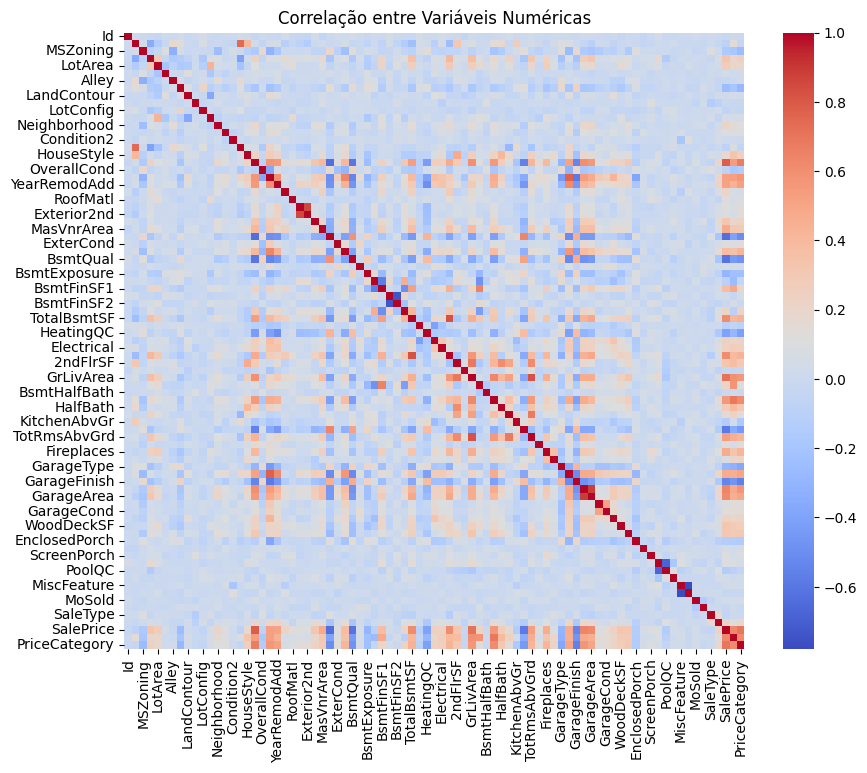

In [16]:
print(df.info())
print(df.describe())

plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm')
plt.title('Correlação entre Variáveis Numéricas')
plt.show()

2) Feature Engineering

In [18]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

df['TotalBathrooms'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Normalização
scaler = StandardScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice')
df[num_cols] = scaler.fit_transform(df[num_cols])

3) Aprendizagem Supervisionada

  a) Regressão Linear

In [19]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo_reg = LinearRegression()
modelo_reg.fit(X_train, y_train)
y_pred = modelo_reg.predict(X_test)

print('--- Regressão Linear ---')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')
print(f'R²: {r2_score(y_test, y_pred):.2f}')

--- Regressão Linear ---
MAE: 21638.87
RMSE: 35379.53
R²: 0.84


  b) Classificação

--- Classificação ---
Acurácia: 0.94
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       161
           1       0.93      0.95      0.94       131

    accuracy                           0.94       292
   macro avg       0.94      0.94      0.94       292
weighted avg       0.94      0.94      0.94       292



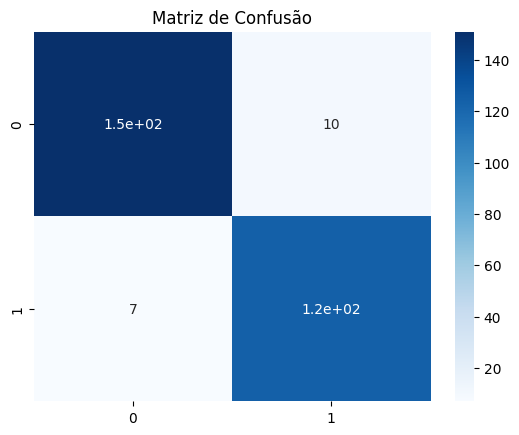

In [11]:
df['PriceCategory'] = (df['SalePrice'] > df['SalePrice'].median()).astype(int)
X = df.drop(columns=['SalePrice', 'PriceCategory'])
y = df['PriceCategory']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo_clf = RandomForestClassifier(random_state=42)
modelo_clf.fit(X_train, y_train)
y_pred = modelo_clf.predict(X_test)

print('--- Classificação ---')
print(f'Acurácia: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

4) Aprendizagem Não Supervisionada

Clusterização

In [20]:
X_cluster = df.select_dtypes(include=['int64', 'float64']).drop(columns=['SalePrice'])
X_scaled = StandardScaler().fit_transform(X_cluster)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
sil = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {sil:.2f}')

Silhouette Score: 0.08


5) Métricas de avaliação e comparação

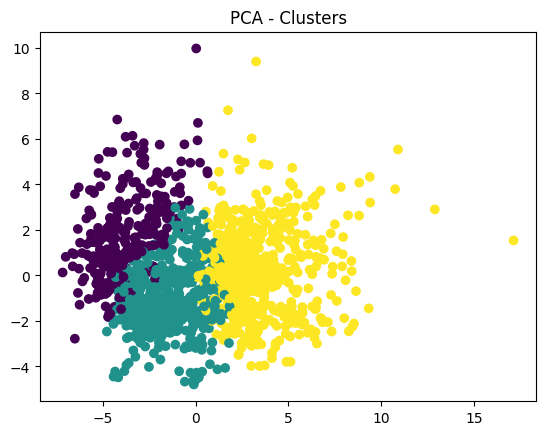

In [13]:
#PCA para visualização
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis')
plt.title('PCA - Clusters')
plt.show()

In [14]:
#ANÁLISE DE ASSOCIAÇÃO
# Selecionar algumas colunas categóricas como se fossem itens de uma transação
basket = df[['CentralAir', 'Street', 'SaleCondition']]

# Transformar em dados binários (presença/ausência)
basket_encoded = pd.get_dummies(basket)

# Garantir que todos os valores sejam apenas 0 ou 1 (dados binários)
basket_encoded = basket_encoded.astype('bool')

# Aplicar o algoritmo Apriori
frequent = apriori(basket_encoded, min_support=0.1, use_colnames=True)

# Regras de associação
rules = association_rules(frequent, metric='lift', min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(CentralAir),(Street),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0
1,(Street),(CentralAir),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0
2,(SaleCondition),(CentralAir),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0
3,(CentralAir),(SaleCondition),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0
4,(SaleCondition),(Street),1.0,1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0,1.0,0.0,1.0


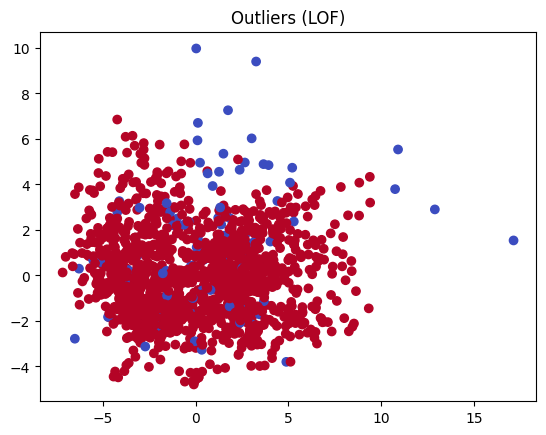

In [15]:
#Outliers com Local Outlier Factor
lof = LocalOutlierFactor()
outliers = lof.fit_predict(X_scaled)
plt.scatter(reduced[:, 0], reduced[:, 1], c=outliers, cmap='coolwarm')
plt.title('Outliers (LOF)')
plt.show()